# Imports

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

import src.data.scrape as scraper
import src.utils.preprocessing as pre
import src.utils.plotting as plot
import src.models.sentiment_analysis as sa
import src.models.topics_extraction as te
import src.models.predictions as pred
import src.models.cooperation as coop

# Data and Pre-Processing
### Part 1: EDA 

In [3]:
data = pre.import_RFA()
print(data.shape)
data.head(5)

(198275, 7)


,SRC,TGT,VOT,RES,YEA,DAT,TXT
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",Support as conom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",Support as nominator.
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",Support per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",Support per noms. BDD is a strong contributor ...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","Support, with great pleasure. I work with BDD ..."


In [4]:
df_processed, df, unique_elections, unique_candidate_freq_table, single_runners_list, multiple_runners_list, flagged_elec_id = pre.preprossess_eda(data)
df1 = df.copy()
votes, df1 = pre.get_votes(df1)

/Users/maxcalamand/Downloads/ada-2024-project-ackthuallydeadalready/src/utils/preprocessing.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_dataset['elec_id'] = np.empty(198275)
/Users/maxcalamand/Downloads/ada-2024-project-ackthuallydeadalready/src/utils/preprocessing.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_dataset['elec_id'] = complete_dataset['elec_id'].astype(int)


In [5]:
#How many people interacted more than once with an election
print('Unique users who interacted with an election more than once: {}'.format(data.duplicated(subset = ['TGT','SRC']).sum()))
#How many people interacted more than once with an election and did not switch votes (at least once)
print('Unique Users who intereacted with an election more than once and did not change votes, at least once: {}'.format(data.duplicated(subset = ['TGT','SRC','VOT']).sum()))
#How many people interacted more than once with an election and did switch votes (at least once)
print('Unique users who intereacted with an election more than once and did change vote, at least once: {}'.format(data.duplicated(subset = ['TGT','SRC']).sum()-data.duplicated(subset = ['TGT','SRC','VOT']).sum()))

Unique users who interacted with an election more than once: 9272
Unique Users who intereacted with an election more than once and did not change votes, at least once: 6824
Unique users who intereacted with an election more than once and did change vote, at least once: 2448


To evaluate election results after the conclusion, we will only take into account final voting decision (ignores prior voting intentions)

After Manually scrolling through the borderline dates, I see that the borderline dates before the new year are labeled with a year of the following year if they have at least one comment in the following year. <strong>This leads me to believe that the documentation is incorrect and that the YEA is for the year that the election ended</strong>. 

All except one TGT in the borderline dates in the new year are properly documented. The one mistake is an accident and there seems to be a duplication of commments with some having the year 2008. Wrong ones were deleted.

- Assumption n°1: Only one election by year
- Assumption n°2: If failed, canidate needs to wait a year before reapplying
- Assumption n°3(VIOLATED): +1 can only be attributed to the final year as it would be improbable that someone passes then has to run again,
    
    It is possible to adminship --> interesting avenue for data analysis

=> Idea is to group the elections by TGT, YEA then RES

#### Things to do:

- Assign unique Election ID (using TGT, YEA, Result)
- Calculate the amount of votes per election
- lost adminship?

- repeat the above for users (voters)
    - voter id 
    - total times voted per election
    - total times votes
    - elected between 2003 and 2013
    - year elected?

In [6]:
data_vote_polarity = pre.process_polarity(df)

In [7]:
# How many candidates run only once (assuming candidates can only run once per year)
# Check if some elections happen across two years (i.e. Dec into Jan)
# Check if we have election id
# Numerator is for single year elections (proxy for one election candidates) from below
(702+681+489+410+274+240+152+100+79+55+28)/data_vote_polarity.groupby(['TGT'])['YEA'].unique().value_counts().sum()

np.float64(0.9179296539891335)

An overwhelming Majority of candidates only run once (92%) irrespective of outcome. 
Next steps: Election statistics by attempts --> pass rate, votes per election, ability to pass second time, margin of loss of the first loss 
Observation: Candidates run on consecutive years, after failing first time

In [8]:
print('90th Percentile: {:.0f}'.format(data_vote_polarity.groupby('TGT')['TXT'].count().quantile(0.9)))
print('95th Percentile: {:.0f}'.format(data_vote_polarity.groupby('TGT')['TXT'].count().quantile(0.95)))
print('99th Percentile: {:.0f}'.format(data_vote_polarity.groupby('TGT')['TXT'].count().quantile(0.99)))

print('\nBehavior of below the 95th percentile (inclusive):')
print(data_vote_polarity.groupby('TGT')['TXT'].count()[data_vote_polarity.groupby('TGT')['TXT'].count()<163+1].describe())

print('\nTail behavior beyond 99th percentile:')
print(data_vote_polarity.groupby('TGT')['TXT'].count()[data_vote_polarity.groupby('TGT')['TXT'].count()>276].describe())

90th Percentile: 120
95th Percentile: 163
99th Percentile: 276

Behavior of below the 95th percentile (inclusive):
count    3322.000000
mean       46.756171
std        37.801955
min         1.000000
25%        14.000000
50%        39.000000
75%        70.000000
max       163.000000
Name: TXT, dtype: float64

Tail behavior beyond 99th percentile:
count     35.000000
mean     420.542857
std      164.334906
min      277.000000
25%      302.000000
50%      361.000000
75%      481.000000
max      987.000000
Name: TXT, dtype: float64


Using the first table, we can see that we have a relatively low median of 39 comments with half our elections having between 14 and 70 comments according to the IQR. 
At the lower end of the range, semantic analysis may be less insightful as we might not have sufficient comments with meaningful sentiment. However, a further analysis of this subset should inspect whether the less comments reflects the candidates compentency, i.e. less to discuss about strong candidates.

In [9]:
print("Candidates who only ran once:", (unique_elections['TGT'].value_counts()==1).sum(),
      "\nCandidates who ran multiple times:", (unique_elections['TGT'].value_counts(dropna=False)>1).sum(),
      "\nTotal unique candidates:",(unique_elections['TGT'].value_counts()<2).sum() +(unique_elections['TGT'].value_counts()>1).sum()) #unique candidates

if ((unique_elections['TGT'].value_counts()<2).sum() +(unique_elections['TGT'].value_counts()>1).sum()) == len(unique_elections['TGT'].value_counts()):
    print('No Data Points Lost')
else:
    print('datapoints lost')

#Pass Rate
print('Pass Rate for single time Runners')
print(unique_elections[unique_elections['TGT'].isin(single_runners_list)]['RES'].value_counts(normalize=True))

print('\nPass Rate for multiple time Runners')
print(unique_elections[unique_elections['TGT'].isin(multiple_runners_list)]['RES'].value_counts(normalize=True))

Candidates who only ran once: 3111 
Candidates who ran multiple times: 386 
Total unique candidates: 3497
No Data Points Lost
Pass Rate for single time Runners
RES
 1    0.532626
-1    0.467374
Name: proportion, dtype: float64

Pass Rate for multiple time Runners
RES
-1    0.674847
 1    0.325153
Name: proportion, dtype: float64


In [10]:
passrate_byYear = pre.passrate_byYear(df)
single_multi_stat = pre.single_multi_stat(unique_elections,single_runners_list,multiple_runners_list)

### Graphs EDA

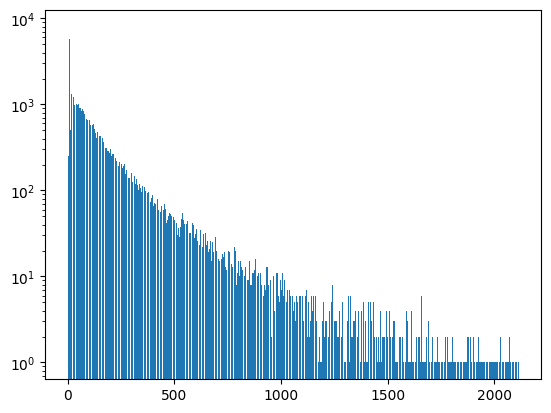

In [11]:
plot.comment_size(df)

The comment size shows a bit on the activity of users in the discussion forum. It can easily be seen that most users have minimal to no comment in the discussion panel with some having a lot

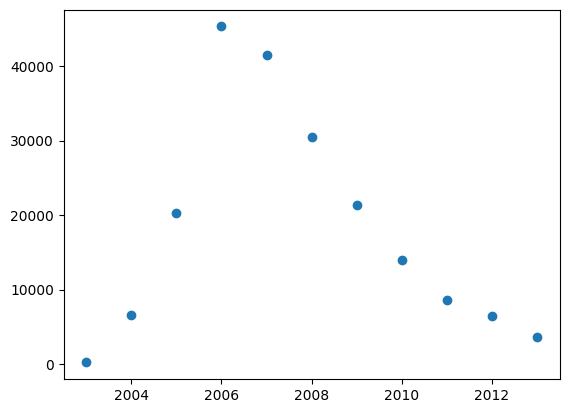

In [12]:
plot.scatter_votes_year(df)

Plots the number of votes per year between the years 2003 and 2013
We can see how the number of votes vary between the years, it peaked in 2006 then it keeps going down

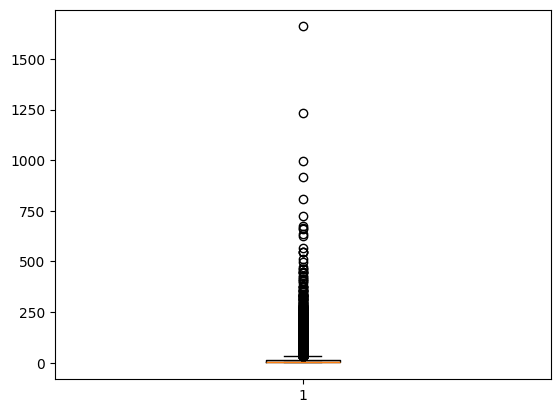

In [13]:
plot.boxplot_votes(df)

We plots the number of votes per user in a box plot format, the 1601 votes outlier is the aggregate of the people whose username was not recorded during their vote. As we can see, there are some groups who votes quite a lot but most people have low participation rate

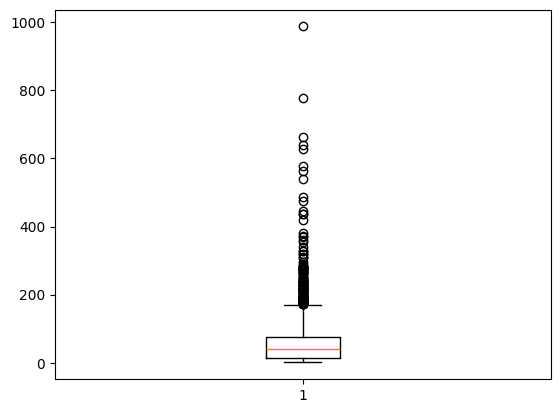

In [14]:
plot.boxplot_votes(df,src='TGT')

Plots the number of votes each candidate has received in a box plot. We can see similar patterns as vote per user as most data values are concentrated around the lower end, while some extreme values (outliers) stretch far above.

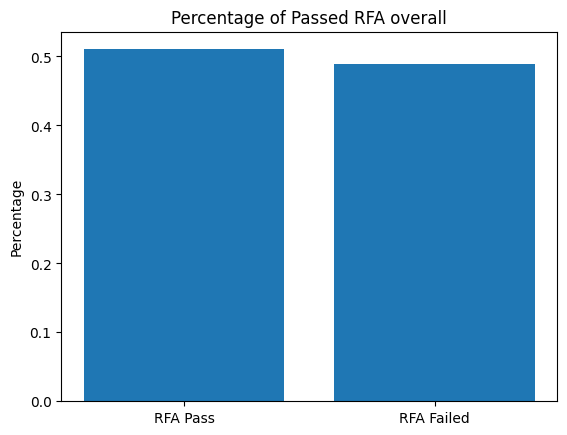

In [15]:
plot.bar_pass_fail(unique_elections)

In [16]:
plot.pass_rate_once_v_mult(single_multi_stat, prt= True)

In [17]:
plot.passrate_byYear_plot(passrate_byYear, prt= True)

In [19]:
plot.outcome_over_time(df1,prt=True)

- Steady shift of the mass towards the right for Wins --> more and more votes needed to win elections
- Mass of rejections stays mostly anchored under 100 votes, but frequency fluctuates a lot --> low election participation is still a eliminating factor but very it's usage fluctuates

In [20]:
plot.voting_behaviors(df1,passrate_byYear,prt=True)

Main Insights: 
- First year can be an anomaly since we don't have any negatives (may be an issue with the data) 
- 2004 onwards, pass rate is between 55% and 75% --> overall, chance of passing each year --> not really affected by growth in volume
- application volume increased till 2006; consistent decline since 2006 --> exponential growth and decline??? --> does wiki RFA have enough admins now?

Questions: 
- Does voter participation also increase over the years: total unique voters per year, elections voted per voter per year?
- should we drop 2003 year --> small sample and potentially tainted --> remove outliers

Tried to see if there's any trend for participants and pass rates --> do we see higher pass rates for elections with more votes or opposite

next steps:
- remove 2003 data since it is only positive?
- plot by year (subplots), add slopes to compare trends (if any)
- try standardizing data

From above, we see that, on average, we have 56.7 for an election.        
Half of our elections will have less than 41 votes.        
The most frequent vote count for an election will be 41 votes        
We can see that the 90% of the elections have less than 120 votes.        


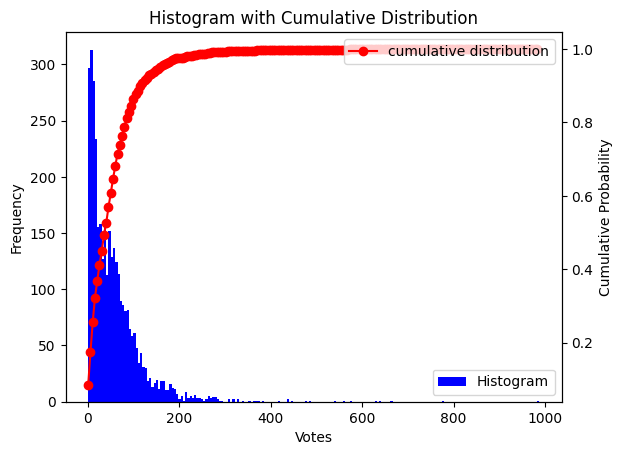

In [25]:
plot.data_by_tgt(data,print_stats=True)

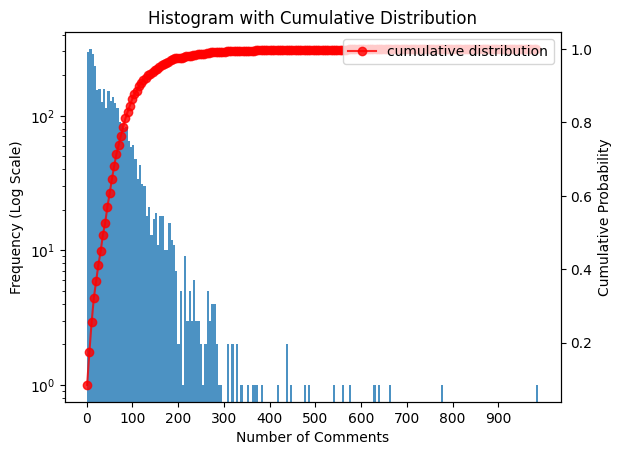

In [26]:
plot.hist_cummul_vote_pol(data_vote_polarity)

In the histogram, we can observe that the bulk of the mass located below 200, with a median around 50.

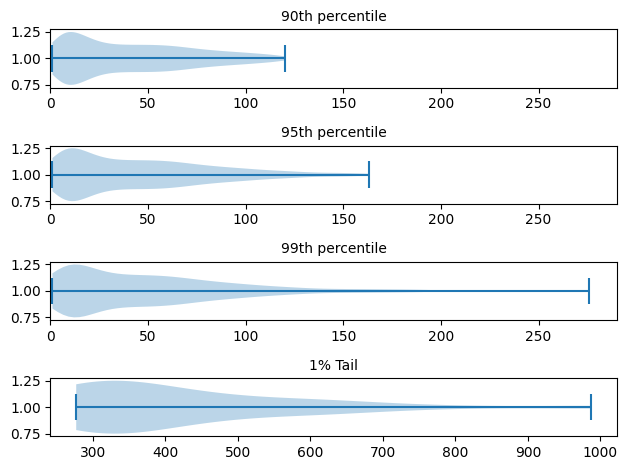

In [27]:
plot.violins(data_vote_polarity)

We can see that distribution is positively skewed with 95% of the mass between 0 and 163 comments per election. There's a 

90th percentile: 48
90th percentile: 90
90th percentile: 238


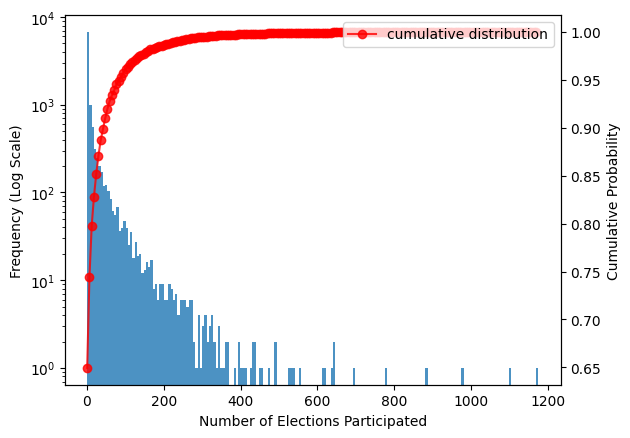

In [28]:
plot.cumulative_elec_particip(data,print_stats=True)

- An election starting in Decemeber will continue in the following year --> Problems: 
    - election statistics by year are double-counting --> use start or final date to account --> Standardize dates to datetime?
- Voters can change votes --> need to adjust pass rates to only account for final voting intention
    - For prediction: How many votes change per election, and are they clustered (could be related to discussion) or random
- how many rejected people come run again?
- Persistence of Negative votes --> what percentage of negative voters in first rejection continue to vote in 2nd election (if exists)
    - how many switch voting camps from negative to positive
- Persistence of positive votes --> what percentage of positive voters in first rejection continue to vote in 2nd election 
    - how many switch voting camps from positive to negative

section title if vote only correlate with own comments --> Grudge Match

### Part 2: Scraping
We already clean the data and preprocess it so we can do some analysis (parsing the vote, replaceing some characters, etc).

In [29]:
data = pre.import_RFA()

In [30]:
test = scraper.scrape_by_name_all_qs_all_attempts(['RadioKirk', 'Rami R'],data)
for name, attempts in test.items():
    for attempt, questions in attempts.items():
        print("NAME: ", name)
        print(attempt)
        for question, answer in questions.items():
            print(f"{question} \n{answer}")

NameError: name 'scraper' is not defined

The following takes more than 5H, but the data from it are saved and re-used.

In [5]:
# full_q_and_a = scraper.scrape_by_name_all_qs_all_attempts(data_scrap['TGT'].unique(),data)

# for name, attempts in full_q_and_a.items():
#     for attempt, questions in attempts.items():
#         print("NAME: ", name)
#         print(attempt)
#         for question, answer in questions.items():
#             print(f"{question} \n{answer}")

### Part 3: Sentiment Analysis and Topics Extraction
#### Sentiment Analysis HuggingFace

In [6]:
# sa.sa_hug(data)

#### Sentiment Analysis Vader

In [7]:
# sa.sa_vader()

#### Topics
We are using keyBERT to extract the main topic in questions and answers. Right now, it is still using dummy questions and answers we manually get since we just want to test the overall topic extraction. Soon, we will automate it with the scraped data and see where each topic can influence the decision of the voting

In [31]:
a,b = te.example_input()
te.extract_topic(a,b)

RuntimeError: Numpy is not available

We extract the topics from the question and answers pairs.

In [9]:
# te.extract_topic_from_df()

Now we also do the same thing for all the TXT in the main dataset

In [10]:
# te.extract_topic_from_df_text()

In [32]:
dfsa, qs = pre.complete_prepro_w_sa_topics()

In [33]:
# data = pre.merge_sa_eda(data_eda,dfsa)
data = pd.read_csv('res/data/merged_id_sa.csv')
data = data.drop(columns=['Unnamed: 0'])
data.head(1)

,SRC,TGT,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id,sentiment,vader_neg,vader_neu,vader_pos,vader_compound,topic_x,topic_y
0,Steel1943,BDD,1,1,2013,2013-04-19,April,23:13:00,Support as conom.,301,POSITIVE,0.0,0.426,0.574,0.4019,support conom,{'best contributions wikipedia'}


In [34]:
plot.linear_pred_influ_vot(dfsa, prt = True)

In [35]:
plot.plot_sentiment_byPass(data,prt=True)

In [36]:
plot.plot_sentiment_byPass(data,vader=True,prt=True)

In [37]:
plot.plot_sentiments_byYear(data,prt=True)

In [38]:
plot.plot_sentiments_byYear(data,vader=True,prt=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/anaconda3/envs/ada/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md




,sentiment,topic_x,topic_y,cluster
0,POSITIVE,support conom,{best contributions wikipedia},0
1,POSITIVE,support nominator,{best contributions wikipedia},0
2,POSITIVE,support noms,{best contributions wikipedia},0
3,POSITIVE,support noms bdd,{best contributions wikipedia},0
4,POSITIVE,admin corps,{best contributions wikipedia},0
...,...,...,...,...
198067,POSITIVE,NaN,{wikipedia particularly pleased},0
198068,POSITIVE,editing work,{wikipedia particularly pleased},0
198069,POSITIVE,candidacy number valuable,{wikipedia particularly pleased},0
198070,NEGATIVE,edits necessary,{wikipedia particularly pleased},0


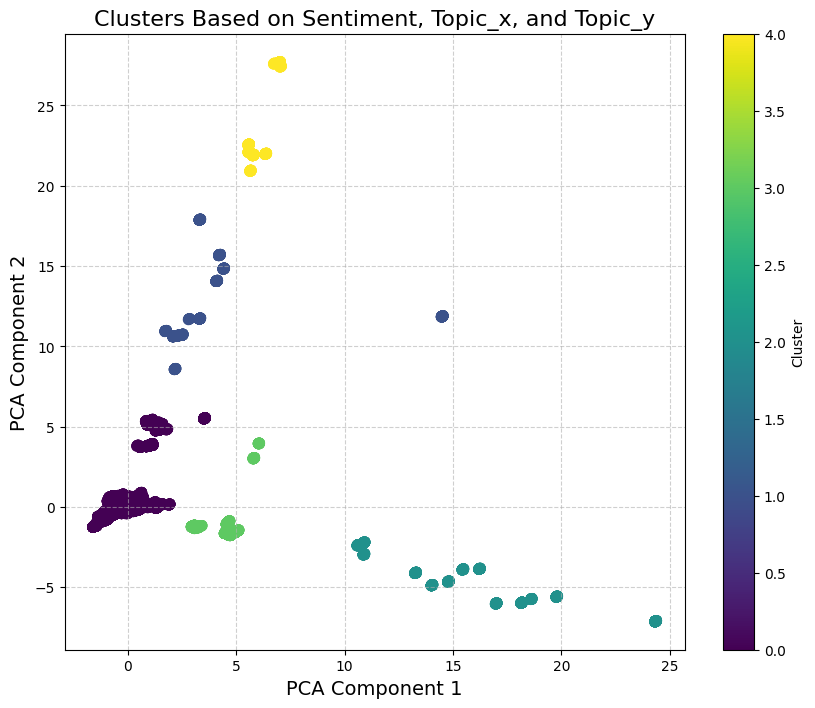

In [39]:
plot.plot_clusters()

Cooperation plot also takes much time but is saved and on the Data Story

In [40]:
# plot.visualize_cooperation()

In [41]:
plot.plot_topics_pass(data,prt=True)

In [42]:
plot.plot_topics_pass(data, comment=False,prt=True)

### Part 4: Models
Theses models are commentated as they take a long time to run

In [12]:
# model, rmse, mae, r2 = pred.preprocess_and_predict(rfa_df)
# model, rmse, mae, r2 = pred.preprocess_and_predict(rfa_df, smote=True)
# model, rmse, mae, r2 = pred.preprocess_and_predict(rfa_df, model_type='small_nn')
# model, rmse, mae, r2 = pred.preprocess_and_predict(rfa_df, model_type='xgboost')
# model, accuracy, report = pred.preprocess_and_predict(rfa_df, model_type='logistic')

- Regression Metrics:
    RMSE: 0.8768
    MAE: 0.7725
    R² Score: 0.1853
- Regression Metrics:
    RMSE: 0.9004
    MAE: 0.8074
    R² Score: 0.1407
- Regression Metrics:
    RMSE: 0.7958
    MAE: 0.6304
    R² Score: 0.3288
- Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
    Regression Metrics:
    RMSE: 0.8243
    MAE: 0.7038
    R² Score: 0.2799
- Classification Metrics:

    Accuracy: 0.4954

                precision    recall  f1-score   support

            -1       0.00      0.00      0.00     12035
            0       0.00      0.00      0.00         0
            1       0.76      0.80      0.78     19537

        accuracy                           0.50     31572
    macro avg       0.25      0.27      0.26     31572
    weighted avg       0.47      0.50      0.48     31572